## Imports

### Tensorflow Imports

In [19]:
import scipy.io as scio
import numpy as np    
import matplotlib.pyplot as plt
import sys
import os
import math
import pprint
import cv2
from scipy.misc import imsave
from helper import *
from create_labels import label_img_to_rgb

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'

import keras
from keras.layers import Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import UpSampling2D
from keras.layers import Concatenate
from keras.layers import Lambda 
from keras.utils import to_categorical
import tensorflow as tf

from keras.layers import Reshape

from keras import backend as K
from keras import regularizers, optimizers
# %matplotlib inline

## Models

### Creating Architecture

In [20]:
h,w = 512, 600
data_shape = h*w
weight_decay = 0.0001
# Defines the input tensor
inputs = Input(shape=(h,w,1))

L1 = Conv2D(64,kernel_size=(3,3),padding = "same",kernel_regularizer=regularizers.l2(weight_decay))(inputs)
L2 = BatchNormalization()(L1)
L2 = Activation('relu')(L2)
#L3 = Lambda(maxpool_1,output_shape = shape)(L2)
L3 = MaxPooling2D(pool_size=(2,2))(L2)
L4 = Conv2D(64,kernel_size=(3,3),padding = "same",kernel_regularizer=regularizers.l2(weight_decay))(L3)
L5 = BatchNormalization()(L4)
L5 = Activation('relu')(L5)
#L6 = Lambda(maxpool_2,output_shape = shape)(L5)
L6 = MaxPooling2D(pool_size=(2,2))(L5)
L7 = Conv2D(64,kernel_size=(3,3),padding = "same",kernel_regularizer=regularizers.l2(weight_decay))(L6)
L8 = BatchNormalization()(L7)
L8 = Activation('relu')(L8)
#L9 = Lambda(maxpool_3,output_shape = shape)(L8)
L9 = MaxPooling2D(pool_size=(2,2))(L8)
L10 = Conv2D(64,kernel_size=(3,3),padding = "same",kernel_regularizer=regularizers.l2(weight_decay))(L9)
L11 = BatchNormalization()(L10)
L11 = Activation('relu')(L11)
L12 = UpSampling2D(size = (2,2))(L11)
#L12 = Lambda(unpool_3,output_shape = unpool_shape)(L11)
L13 = Concatenate(axis = 3)([L8,L12])
L14 = Conv2D(64,kernel_size=(3,3),padding = "same",kernel_regularizer=regularizers.l2(weight_decay))(L13)
L15 = BatchNormalization()(L14)
L15 = Activation('relu')(L15)
L16 = UpSampling2D(size= (2,2))(L15)
#L16 = Lambda(unpool_2,output_shape=unpool_shape)(L15)
L17 = Concatenate(axis = 3)([L16,L5])
L18 = Conv2D(64,kernel_size=(3,3),padding = "same",kernel_regularizer=regularizers.l2(weight_decay))(L17)
L19 = BatchNormalization()(L18)
L19 = Activation('relu')(L19)
#L20 = Lambda(unpool_1,output_shape=unpool_shape)(L19)
L20 = UpSampling2D(size=(2,2),name = "Layer19")(L19)
L21 = Concatenate(axis=3)([L20,L2])
L22 = Conv2D(64,kernel_size=(3,3),padding = "same",kernel_regularizer=regularizers.l2(weight_decay))(L21)
L23 = BatchNormalization()(L22)
L23 = Activation('relu')(L23)
L24 = Conv2D(8,kernel_size=(1,1),padding = "same",kernel_regularizer=regularizers.l2(weight_decay))(L23)
L = Reshape((data_shape,8),input_shape = (h,w,8))(L24)
L = Activation('softmax')(L)
model = Model(inputs = inputs, outputs = L)
# model.summary()

### Setting Directory

In [21]:
# Setting the directories
import os

wanted_folder = 'alldata/'
# wanted_folder = 'pruned/'
# wanted_folder = 'Atrium/'
# wanted_folder = 'Ventricle/'

cwd = os.getcwd()
check_directory = cwd
results_folder = cwd + '/results'
if check_directory == '/home/sim/notebooks/relaynet_pytorch':
    cwd = cwd + '/datasets/OCTData/'+wanted_folder
elif check_directory == '/Users/sim/Desktop/Imperial/Project/PreTrained/relaynet_pytorch':
    cwd = cwd + '/datasets-24-aug/OCTData/'+wanted_folder

print(cwd)

/home/sim/notebooks/relaynet_pytorch/datasets/OCTData/alldata/


### Loading Model

In [59]:
saved_name = 'atrvennormalise_bs_40_ep_200'
model.load_weights(check_directory+"/models/Normalised/"+saved_name+".hdf5")

65
(512, 600)


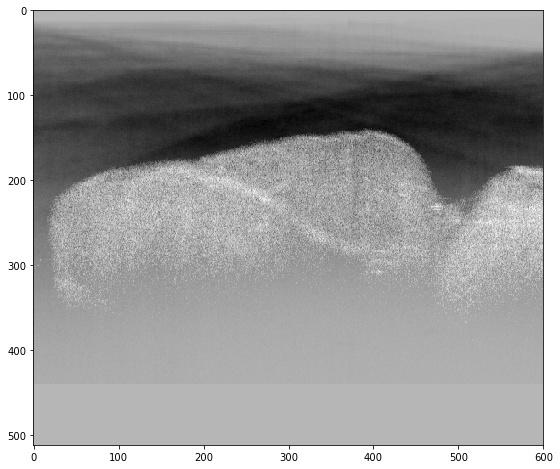

In [60]:
# filenames, raw_images = get_data(cwd+'whole_raw_image','.tif')
# filenames, raw_images = get_data(cwd+'normalised_raw_image','.png')
filenames, raw_images = get_data(cwd+'normalised_raw_2','.png')

save_name = results_folder + '/Normalised/'+ 'tf_' + 'atrven_normalised' + '.npy'
print(len(raw_images))
print (raw_images[0].shape)
plt.imshow(raw_images[2],cmap = "gray")

In [61]:
stored_images = []
for i in range(len(raw_images)):
    testing_image = raw_images[i]
    h,w = testing_image.shape
    testing_image = testing_image.reshape((1,h,w,1))
    prediction = model.predict(testing_image)
    prediction = np.squeeze(prediction,axis = 0)
    prediction = np.reshape(prediction,(h,w,8))
    predicted_id = np.zeros((h,w))
    for i in range(h):
        for j in range(w):
            index = np.argmax(prediction[i][j]) # doing pixel wise prediction based on highest prob of class
            predicted_id[i][j] = index

    stored_images.append(predicted_id)
stored_images = np.asarray(stored_images)

np.save(save_name,stored_images)
# idxs = label_img_to_rgb(out)
# plt.imshow(idxs)
# plt.show()

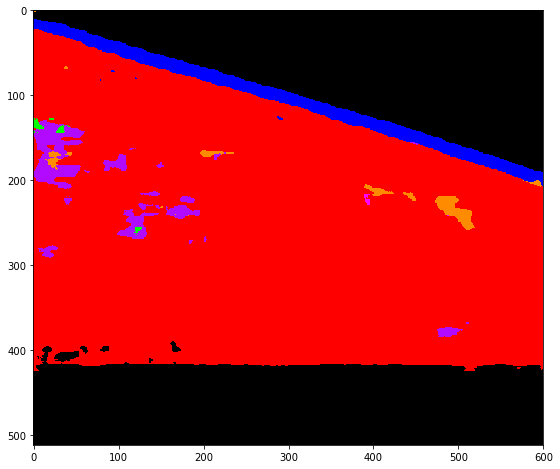

In [62]:
idxs = label_img_to_rgb(predicted_id)
plt.imshow(idxs)
plt.show()